In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.integrate import quad
from scipy.stats import wasserstein_distance

In [15]:
# 目标混合高斯分布参数
weights = [0.3, 0.7]
means = [4, 7]
std_devs = [np.sqrt(0.3), np.sqrt(2)]

def target_pdf(x):
    return weights[0] * norm.pdf(x, means[0], std_devs[0]) + weights[1] * norm.pdf(x, means[1], std_devs[1])

def U(x):
    return -np.log(max(target_pdf(x), 1e-300))

def grad_U(x):
    # 计算 ∇U(x) = -∇log p(x)
    # 对于混合高斯分布：
    p = target_pdf(x)
    dp_dx = (weights[0] * norm.pdf(x, means[0], std_devs[0]) * (- (x - means[0]) / (std_devs[0]**2)) +
             weights[1] * norm.pdf(x, means[1], std_devs[1]) * (- (x - means[1]) / (std_devs[1]**2)))
    return dp_dx / max(p, 1e-300)

def leapfrog(x, p, epsilon, L):
    x_new = x
    p_new = p - 0.5 * epsilon * grad_U(x_new)
    for _ in range(L):
        x_new = x_new + epsilon * p_new
        if _ != L - 1:
            p_new = p_new - epsilon * grad_U(x_new)
    p_new = p_new - 0.5 * epsilon * grad_U(x_new)
    return x_new, p_new

def HMC_sampling(x0, num_samples, epsilon, L):
    samples = []
    x_current = x0
    for i in range(num_samples):
        p_current = np.random.normal(0, 1)
        x_proposed, p_proposed = leapfrog(x_current, p_current, epsilon, L)
        
        # 计算哈密尔顿量
        current_U = U(x_current)
        current_K = 0.5 * p_current**2
        proposed_U = U(x_proposed)
        proposed_K = 0.5 * p_proposed**2
        
        # 接受概率
        delta_H = (proposed_U + proposed_K) - (current_U + current_K)
        if np.random.uniform(0, 1) < np.exp(-delta_H):
            samples.append(x_proposed)
            x_current = x_proposed
        else:
            samples.append(x_current)
            
        if i % 1000 == 0: 
            print(f"Step {i}/{num_samples} | x_current: {x_current:.4f}")
            
    return np.array(samples)

In [16]:
# 参数设置
x0 = 0.0          # 初始位置
num_samples = 10000
epsilon = 0.01     # 步长
L = 20           # 步数
samples = HMC_sampling(x0, num_samples, epsilon, L)

# 丢弃前1000个作为烧入期
burn_in = 1000
samples = samples[burn_in:]

Step 0/10000 | x_current: 0.0000
Step 1000/10000 | x_current: 3.9610
Step 2000/10000 | x_current: 4.8614
Step 3000/10000 | x_current: 4.1348
Step 4000/10000 | x_current: 4.6500
Step 5000/10000 | x_current: 8.0721
Step 6000/10000 | x_current: 4.9580
Step 7000/10000 | x_current: 5.7020
Step 8000/10000 | x_current: 8.4588
Step 9000/10000 | x_current: 6.0988


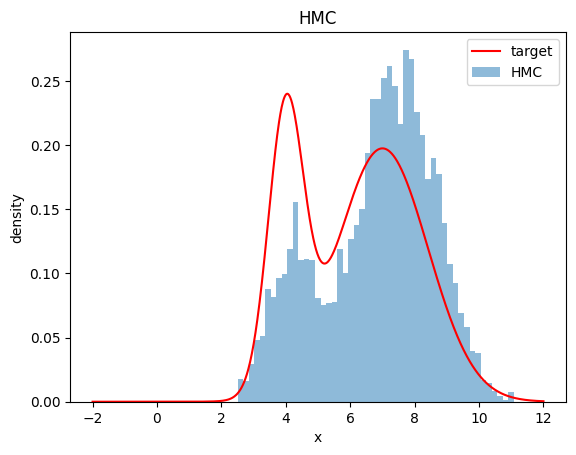

In [17]:
# 绘制目标分布和采样分布
x_vals = np.linspace(-2, 12, 1000)
plt.plot(x_vals, target_pdf(x_vals), label='target', color='red')
plt.hist(samples, bins=50, density=True, alpha=0.5, label='HMC')
plt.legend()
plt.xlabel('x')
plt.ylabel('density')
plt.title('HMC')
plt.show()

In [18]:
def kl_divergence(samples, x_min=-2, x_max=12, num_points=1000):
    x_vals = np.linspace(x_min, x_max, num_points)
    dx = x_vals[1] - x_vals[0]
    p = target_pdf(x_vals)
    # 估计采样分布的密度
    hist, _ = np.histogram(samples, bins=num_points, range=(x_min, x_max), density=True)
    q = hist
    # 防止log(0)
    q = np.maximum(q, 1e-300)
    kl = np.sum(p * np.log(p / q)) * dx
    return kl

kl = kl_divergence(samples)
print(f"KL散度: {kl}")

KL散度: 6.33029851928784


In [19]:
wasserstein_dist = wasserstein_distance(samples, 
                                       [means[0]] * int(weights[0]*num_samples) + [means[1]] * int(weights[1]*num_samples))
print(f"Wasserstein距离: {wasserstein_dist}")

Wasserstein距离: 0.9324564552434076


In [20]:
#目标分布的统计量
target_mean = weights[0]*means[0] + weights[1]*means[1]
target_var = weights[0]*(std_devs[0]**2 + (means[0]-target_mean)**2) + weights[1]*(std_devs[1]**2 + (means[1]-target_mean)**2)
#采样分布的统计量
sample_mean = np.mean(samples)
sample_var = np.var(samples)
print(f"目标均值: {target_mean}, 采样均值: {sample_mean}")
print(f"目标方差: {target_var}, 采样方差: {sample_var}")

目标均值: 6.1, 采样均值: 6.795477617058855
目标方差: 3.38, 采样方差: 3.059078095542414
